In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# 1. Load dataset


In [2]:
df = pd.read_csv("/content/House2_data.csv")

# Pastikan kolom Time menjadi datetime
df["Time"] = pd.to_datetime(df["Time"])

# Sortir sesuai waktu (jaga urutan)
df = df.sort_values("Time")

# Target
target = "Use [kW]"

# 2. Buat lag features


In [3]:
def create_lags(data, col, n_lags=24):
    df_lags = data.copy()
    for lag in range(1, n_lags+1):
        df_lags[f"{col}_lag{lag}"] = df_lags[col].shift(lag)
    return df_lags

df_lagged = create_lags(df, target, n_lags=24)

# Drop baris NaN (karena shift)
df_lagged = df_lagged.dropna()

# 3. Split Train-Test


In [4]:
train_size = int(0.8 * len(df_lagged))
train = df_lagged.iloc[:train_size]
test = df_lagged.iloc[train_size:]

X_train = train.drop(columns=[target, "Time"])
y_train = train[target]
X_test = test.drop(columns=[target, "Time"])
y_test = test[target]

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Train shape: (6988, 43)  Test shape: (1748, 43)


# 4. Train Model


In [5]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Simpan model
joblib.dump(model, "rf_forecasting_model.pkl")

['rf_forecasting_model.pkl']

# 5. Evaluasi


In [8]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

MAE : 0.17657699058678203
RMSE: 0.05287333157184558
R²  : 0.961420873614125


# 6. Visualisasi


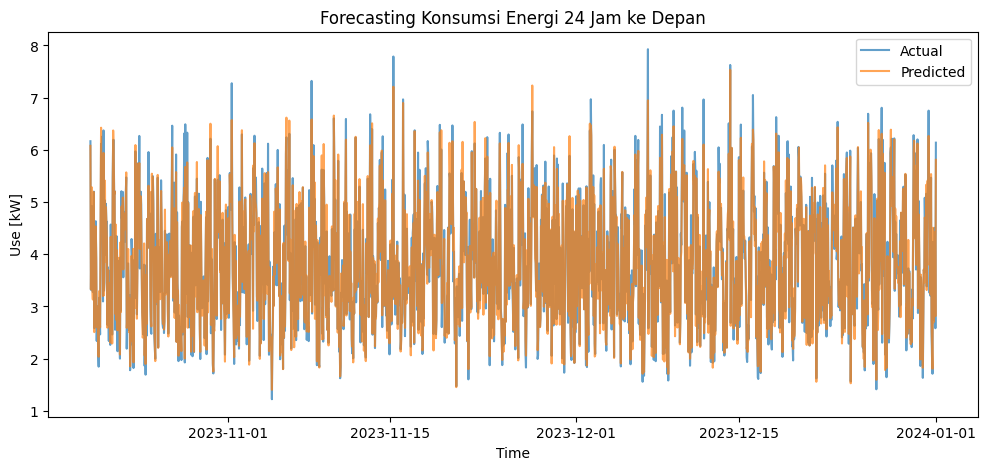

In [9]:
plt.figure(figsize=(12,5))
plt.plot(test["Time"], y_test.values, label="Actual", alpha=0.7)
plt.plot(test["Time"], y_pred, label="Predicted", alpha=0.7)
plt.title("Forecasting Konsumsi Energi 24 Jam ke Depan")
plt.xlabel("Time")
plt.ylabel("Use [kW]")
plt.legend()
plt.show()

#7. Testing pada test set (data historis yang dipisah dari training)

In [10]:
# Prediksi pada test set
y_pred = model.predict(X_test)

# Bandingkan dengan aktual
comparison = pd.DataFrame({
    "Time": test["Time"].values,
    "Actual": y_test.values,
    "Predicted": y_pred
})

print(comparison.head(10))  # tampilkan 10 baris pertama


                 Time    Actual  Predicted
0 2023-10-20 04:00:00  6.164568   6.076275
1 2023-10-20 05:00:00  3.319010   3.327369
2 2023-10-20 06:00:00  4.386583   4.511766
3 2023-10-20 07:00:00  4.918178   5.280414
4 2023-10-20 08:00:00  3.398232   3.341573
5 2023-10-20 09:00:00  3.274518   3.131918
6 2023-10-20 10:00:00  4.289653   4.027107
7 2023-10-20 11:00:00  5.198361   5.191209
8 2023-10-20 12:00:00  2.583365   2.507129
9 2023-10-20 13:00:00  3.901360   3.577861


#2. Testing untuk forecast masa depan (future prediction)

In [12]:
future_steps = 24  # prediksi 24 jam ke depan
last_row = df_lagged.iloc[-1:]  # baris terakhir dengan lag lengkap

future_preds = []
current_features = last_row.drop(columns=[target, "Time"]).values[0]

for step in range(future_steps):
    # Prediksi jam berikutnya
    pred = model.predict([current_features])[0]
    future_preds.append(pred)

    # Geser lag: buang lag tertua, tambahkan prediksi baru sebagai lag1
    current_features = np.roll(current_features, 1)  # geser ke kanan
    current_features[0] = pred  # lag1 diisi hasil prediksi

# Simpan hasil ke DataFrame
future_times = pd.date_range(start=df["Time"].iloc[-1] + pd.Timedelta(hours=1), periods=future_steps, freq="H")
future_df = pd.DataFrame({"Time": future_times, "Forecast": future_preds})

print(future_df)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

                  Time  Forecast
0  2024-01-01 00:00:00  5.808055
1  2024-01-01 01:00:00  2.172883
2  2024-01-01 02:00:00  2.716352
3  2024-01-01 03:00:00  2.772654
4  2024-01-01 04:00:00  6.668594
5  2024-01-01 05:00:00  6.735029
6  2024-01-01 06:00:00  6.595479
7  2024-01-01 07:00:00  1.456137
8  2024-01-01 08:00:00  1.395905
9  2024-01-01 09:00:00  2.159702
10 2024-01-01 10:00:00  2.759721
11 2024-01-01 11:00:00  6.557346
12 2024-01-01 12:00:00  4.141014
13 2024-01-01 13:00:00  4.588810
14 2024-01-01 14:00:00  4.547035
15 2024-01-01 15:00:00  6.646973
16 2024-01-01 16:00:00  6.729600
17 2024-01-01 17:00:00  6.714603
18 2024-01-01 18:00:00  3.298772
19 2024-01-01 19:00:00  3.317613
20 2024-01-01 20:00:00  4.142753
21 2024-01-01 21:00:00  4.602857
22 2024-01-01 22:00:00  6.636596
23 2024-01-01 23:00:00  5.771039


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/